# LB 0.628873
v5版疑惑
1. 這版試著把 mean encoding by conam拿掉 看起來沒用
2. 多做freq encoding相關

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,StratifiedKFold,cross_validate

from sklearn.metrics import confusion_matrix,f1_score
import time
import random
import os
import sys


# from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
#                               GradientBoostingClassifier, ExtraTreesClassifier)
# import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier


path_raw_data = '../raw_data'
# path_processed_data = '../Data/processed'
# path_prediction_data = '../Data/predictions'
col_target = 'fraud_ind'
col_id = 'txkey'
pd.options.display.max_columns=None

# 1. loading data

In [2]:
time_start = time.time()
df_train = pd.read_csv(os.path.join(path_raw_data, 'train.csv'))
df_test = pd.read_csv(os.path.join(path_raw_data, 'test.csv'))
time_end = time.time()
print('spent: {}'.format(time_end-time_start))

spent: 3.2580766677856445


In [3]:
df_train_id = df_train[col_id]
df_test_id = df_test[col_id]
target = df_train[col_target]

df_train.drop([col_id], axis = 1, inplace = True)
df_test.drop([col_id], axis = 1, inplace = True)


### drop duplicates

In [4]:
df_train = df_train.drop_duplicates(keep = 'first')
ntrain = df_train.shape[0]

In [5]:
df_full = pd.concat((df_train,df_test),sort = False).reset_index(drop = True)
print(df_train.shape, df_test.shape, df_full.shape)

(1516988, 22) (421665, 21) (1938653, 22)


# 2. EDA

# 3. preprocessing

In [6]:
# generate time feature ( format hhmmss)
df_full['loctm_time'] = df_full['loctm'].apply(lambda x: '0'*(6 - len(str(int(x)))) + str(int(x)))
df_full['loctm_time'] = df_full['loctm_time'].apply(lambda x: x[:2] + ':' + x[2:4] + ':' + x[4:])
df_full['loctm_time'] = pd.to_datetime(df_full['loctm_time'], format='%H:%M:%S')

In [7]:
df_full.insert(3,'time_hour', df_full['loctm_time'].dt.hour)
df_full.insert(3,'time_min', df_full['loctm_time'].dt.minute)
df_full.insert(3,'time_sec', df_full['loctm_time'].dt.second)

In [8]:
df_full.head()

,acqic,bacno,cano,time_sec,time_min,time_hour,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,loctm_time
0,6881,113261,38038,52,26,17,513.80,5,0,N,0,N,N,0.0,5,N,0,33,172652.0,457,59333,N,0,102,0,1900-01-01 17:26:52
1,0,134508,45725,14,51,10,465.62,5,0,N,2,N,N,0.0,0,N,0,9,105114.0,451,0,N,5817,102,0,1900-01-01 10:51:14
2,6881,15408,188328,58,24,15,513.80,5,0,N,0,N,N,0.0,5,N,0,6,152458.0,457,59333,N,0,102,0,1900-01-01 15:24:58
3,6716,157159,29967,46,29,17,1016.11,5,62,N,5,N,N,0.0,5,N,0,5,172946.0,247,50436,N,3281,102,0,1900-01-01 17:29:46
4,5975,105985,81305,29,21,18,713.66,5,62,N,4,N,N,0.0,5,N,0,6,182129.0,263,93775,N,5817,102,0,1900-01-01 18:21:29


# 4. Feature Engineering

## 4.1 generate columns using conam

## 4.1.1 Groupby bacno, locdt, loctm

In [9]:
# 這版先把4.1.1拿掉

## 4.1.2 Groupby bacno to compute conam

In [10]:
bycol_num = 1
df_full_groupby = df_full.groupby(['bacno']).agg(
    {'conam':['max','min','sum','count','mean','median']})

df_full_groupby.columns = df_full_groupby.columns.droplevel()
df_full_groupby.reset_index(inplace = True)

In [11]:
col_feature = df_full_groupby.columns.tolist()
for i in range(len(col_feature[bycol_num:])):
    col_feature[bycol_num+i] = col_feature[bycol_num+i] + '_bybacno'

df_full_groupby.columns = col_feature

In [12]:
df_full = df_full.merge(df_full_groupby, on = ['bacno'], how = 'left')

In [13]:
# df_full.head()

## 4.1.3 Groupby bacno with other feature to compute conam

In [14]:
col_FE = ['time_hour','cano','contp', 'etymd', 'mchno',
          'acqic', 'mcc', 'stocn', 'scity', 'stscd', 'csmcu']
bycol_num = 2


for col in col_FE:
    df_full_groupby = df_full.groupby(['bacno',col]).agg(
        {'conam':['max','min','sum','count','mean','median']})
    
    df_full_groupby.columns = df_full_groupby.columns.droplevel()
    df_full_groupby.reset_index(inplace = True)
    col_feature = df_full_groupby.columns.tolist()
    for i in range(len(col_feature[bycol_num:])):
        col_feature[bycol_num+i] = col_feature[bycol_num+i] + '_bybacno_by' + col
    
    df_full_groupby.columns = col_feature
    
    # Merge Data
    df_full = df_full.merge(df_full_groupby, on = ['bacno',col], how = 'left')

## 4.1.4 Groupby bacno and stocn with other feature to compute conam

In [15]:
col_FE = ['time_hour','cano','contp', 'etymd', 'mchno',
          'acqic', 'mcc', 'scity', 'stscd', 'csmcu']
bycol_num = 3


for col in col_FE:
    df_full_groupby = df_full.groupby(['bacno','stocn',col]).agg(
        {'conam':['max','min','sum','count','mean','median']})
    
    df_full_groupby.columns = df_full_groupby.columns.droplevel()
    df_full_groupby.reset_index(inplace = True)
    col_feature = df_full_groupby.columns.tolist()
    for i in range(len(col_feature[bycol_num:])):
        col_feature[bycol_num+i] = col_feature[bycol_num+i] + '_bybacno_bystocn_by' + col
    
    df_full_groupby.columns = col_feature
    
    # Merge Data
    df_full = df_full.merge(df_full_groupby, on = ['bacno','stocn',col], how = 'left')

## 4.1.2 Groupby cano to compute conam

In [16]:
bycol_num = 1
df_full_groupby = df_full.groupby(['cano']).agg(
    {'conam':['max','min','sum','count','mean','median']})

df_full_groupby.columns = df_full_groupby.columns.droplevel()
df_full_groupby.reset_index(inplace = True)

In [17]:
col_feature = df_full_groupby.columns.tolist()
for i in range(len(col_feature[bycol_num:])):
    col_feature[bycol_num+i] = col_feature[bycol_num+i] + '_bycano'

df_full_groupby.columns = col_feature

In [18]:
df_full = df_full.merge(df_full_groupby, on = ['cano'], how = 'left')

In [19]:
# df_full.head()

## 4.1.3 Groupby cano with other feature to compute conam

In [20]:
col_FE = ['time_hour','contp', 'etymd', 'mchno',
          'acqic', 'mcc', 'stocn', 'scity', 'stscd', 'csmcu']
bycol_num = 2


for col in col_FE:
    df_full_groupby = df_full.groupby(['cano',col]).agg(
        {'conam':['max','min','sum','count','mean','median']})
    
    df_full_groupby.columns = df_full_groupby.columns.droplevel()
    df_full_groupby.reset_index(inplace = True)
    col_feature = df_full_groupby.columns.tolist()
    for i in range(len(col_feature[bycol_num:])):
        col_feature[bycol_num+i] = col_feature[bycol_num+i] + '_bycano_by' + col
    
    df_full_groupby.columns = col_feature
    
    # Merge Data
    df_full = df_full.merge(df_full_groupby, on = ['cano',col], how = 'left')

## 4.1.4 Groupby cano and stocn with other feature to compute conam

In [ ]:
col_FE = ['time_hour','contp', 'etymd', 'mchno',
          'acqic', 'mcc', 'scity', 'stscd', 'csmcu']
bycol_num = 3


for col in col_FE:
    df_full_groupby = df_full.groupby(['cano','stocn',col]).agg(
        {'conam':['max','min','sum','count','mean','median']})
    
    df_full_groupby.columns = df_full_groupby.columns.droplevel()
    df_full_groupby.reset_index(inplace = True)
    col_feature = df_full_groupby.columns.tolist()
    for i in range(len(col_feature[bycol_num:])):
        col_feature[bycol_num+i] = col_feature[bycol_num+i] + '_bycano_bystocn_by' + col
    
    df_full_groupby.columns = col_feature
    
    # Merge Data
    df_full = df_full.merge(df_full_groupby, on = ['cano','stocn',col], how = 'left')

## 4.2 create new categorical features

## 4.3 Encoding

### 4.3.1 Frequency Encoding: 
Categorical Feature: ['contp', 'etymd', 'mchno', 'acqic', 'mcc', 'stocn', 'scity', 'stscd', 'csmcu'] 代表該值出現的頻率 by bacno

#### bacno

In [ ]:
frequency_encoding_features = ['time_hour','contp', 'etymd', 'mchno',
                               'acqic', 'mcc', 'stocn', 'scity', 'stscd', 'csmcu']
for col in frequency_encoding_features:
    frequency = df_full.groupby(['bacno',col]).size() / df_full.groupby(['bacno']).size()
    frequency = pd.DataFrame(frequency)
    frequency.reset_index(inplace = True)
    frequency.rename(columns = {0: 'fre_bacno_{}'.format(col)},inplace = True)
    
    df_full = df_full.merge(frequency, on = ['bacno',col], how ='left')

#### cano

In [ ]:
frequency_encoding_features = ['time_hour','contp', 'etymd', 'mchno',
                               'acqic', 'mcc', 'stocn', 'scity', 'stscd', 'csmcu']
for col in frequency_encoding_features:
    frequency = df_full.groupby(['cano',col]).size() / df_full.groupby(['cano']).size()
    frequency = pd.DataFrame(frequency)
    frequency.reset_index(inplace = True)
    frequency.rename(columns = {0: 'fre_cano_{}'.format(col)},inplace = True)
    
    df_full = df_full.merge(frequency, on = ['cano',col], how ='left')

#### 'stocn'

In [ ]:
col_by = 'stocn'
frequency_encoding_features = ['time_hour','contp', 'etymd', 'mchno',
                               'acqic', 'mcc', 'stocn', 'scity', 'stscd', 'csmcu']

for col in frequency_encoding_features:
    if col != col_by:
        frequency = df_full.groupby([col_by,col]).size() / df_full.groupby([col_by]).size()
        frequency = pd.DataFrame(frequency)
        frequency.reset_index(inplace = True)
        frequency.rename(columns = {0: 'fre_{}'.format(col_by)+'_{}'.format(col)},inplace = True)

        df_full = df_full.merge(frequency, on = [col_by,col], how ='left')

#### 'scity'

In [ ]:
col_by = 'scity'
frequency_encoding_features = ['time_hour','contp', 'etymd', 'mchno',
                               'acqic', 'mcc', 'stocn', 'scity', 'stscd', 'csmcu']

for col in frequency_encoding_features:
    if col != col_by:
        frequency = df_full.groupby([col_by,col]).size() / df_full.groupby([col_by]).size()
        frequency = pd.DataFrame(frequency)
        frequency.reset_index(inplace = True)
        frequency.rename(columns = {0: 'fre_{}'.format(col_by)+'_{}'.format(col)},inplace = True)

        df_full = df_full.merge(frequency, on = [col_by,col], how ='left')

#### 'csmcu'

In [ ]:
col_by = 'csmcu'
frequency_encoding_features = ['time_hour','contp', 'etymd', 'mchno',
                               'acqic', 'mcc', 'stocn', 'scity', 'stscd', 'csmcu']

for col in frequency_encoding_features:
    if col != col_by:
        frequency = df_full.groupby([col_by,col]).size() / df_full.groupby([col_by]).size()
        frequency = pd.DataFrame(frequency)
        frequency.reset_index(inplace = True)
        frequency.rename(columns = {0: 'fre_{}'.format(col_by)+'_{}'.format(col)},inplace = True)

        df_full = df_full.merge(frequency, on = [col_by,col], how ='left')

#### 'mcc'

In [ ]:
col_by = 'mcc'
frequency_encoding_features = ['time_hour','contp', 'etymd', 'mchno',
                               'acqic', 'mcc', 'stocn', 'scity', 'stscd', 'csmcu']

for col in frequency_encoding_features:
    if col != col_by:
        frequency = df_full.groupby([col_by,col]).size() / df_full.groupby([col_by]).size()
        frequency = pd.DataFrame(frequency)
        frequency.reset_index(inplace = True)
        frequency.rename(columns = {0: 'fre_{}'.format(col_by)+'_{}'.format(col)},inplace = True)

        df_full = df_full.merge(frequency, on = [col_by,col], how ='left')

#### 'stocn','scity'

In [ ]:
frequency_encoding_features = ['time_hour','contp', 'etymd', 'mchno',
                               'acqic', 'mcc' , 'stscd', 'csmcu']
for col in frequency_encoding_features:
    frequency = df_full.groupby(['stocn','scity',col]).size() / df_full.groupby(['stocn','scity']).size()
    frequency = pd.DataFrame(frequency)
    frequency.reset_index(inplace = True)
    frequency.rename(columns = {0: 'fre_stocn_scity_{}'.format(col)},inplace = True)
    
    df_full = df_full.merge(frequency, on = ['stocn','scity',col], how ='left')

#### 'bacno','scity'

In [ ]:
frequency_encoding_features = ['time_hour','contp', 'etymd', 'mchno',
                               'acqic', 'mcc', 'stocn', 'stscd', 'csmcu']
for col in frequency_encoding_features:
    frequency = df_full.groupby(['bacno','scity',col]).size() / df_full.groupby(['bacno','scity']).size()
    frequency = pd.DataFrame(frequency)
    frequency.reset_index(inplace = True)
    frequency.rename(columns = {0: 'fre_bacno_scity_{}'.format(col)},inplace = True)
    
    df_full = df_full.merge(frequency, on = ['bacno','scity',col], how ='left')

#### 'bacno','stocn'

In [ ]:
frequency_encoding_features = ['time_hour','contp', 'etymd', 'mchno',
                               'acqic', 'mcc', 'scity', 'stscd', 'csmcu']
for col in frequency_encoding_features:
    frequency = df_full.groupby(['bacno','stocn',col]).size() / df_full.groupby(['bacno','stocn']).size()
    frequency = pd.DataFrame(frequency)
    frequency.reset_index(inplace = True)
    frequency.rename(columns = {0: 'fre_bacno_stocn_{}'.format(col)},inplace = True)
    
    df_full = df_full.merge(frequency, on = ['bacno','stocn',col], how ='left')

### 4.3.2 Mean encoding 
Categorical Feature: ['contp', 'etymd', 'mchno', 'acqic', 'mcc', 'stocn', 'scity', 'stscd', 'csmcu']   
target:conam

#### mean for all conam 

In [ ]:
mean_encoding_features = ['time_hour','contp', 'etymd', 'mchno',
                          'acqic', 'mcc', 'stocn', 'scity', 'stscd', 'csmcu']

In [ ]:
for col in mean_encoding_features:
    # 舊版的FE是用df_train(from train data feature to test data)
    mean_encoder = df_full.groupby([col])['conam'].mean()
    df_full.loc[:, 'mean_encoding_{}'.format(col)] = df_full[col].map(mean_encoder)

#### mean by stocn for all conam

In [ ]:
mean_encoding_features = ['time_hour','contp', 'etymd', 'mchno',
                          'acqic', 'mcc', 'scity', 'stscd', 'csmcu']

In [ ]:
for col in mean_encoding_features:
    # 舊版的FE是用df_train
    mean_encoder = df_full.groupby(['stocn',col])['conam'].mean()
    df_full.loc[:, 'mean_encoding_bystocn_{}'.format(col)] = df_full[col].map(mean_encoder)

#### mean by scity for all conam

In [ ]:
mean_encoding_features = ['time_hour','contp', 'etymd', 'mchno',
                          'acqic', 'mcc','stocn', 'stscd', 'csmcu']

In [ ]:
for col in mean_encoding_features:
    # 舊版的FE是用df_train
    mean_encoder = df_full.groupby(['scity',col])['conam'].mean()
    df_full.loc[:, 'mean_encoding_byscity_{}'.format(col)] = df_full[col].map(mean_encoder)

### 4.3.3 Onehot encoding

In [ ]:
df_full = pd.get_dummies(df_full)

### Fillna

In [ ]:
# Fill NaN, 此处排除 fraud_ind
for col in df_full.columns:
    if col != 'fraud_ind':
        df_full[col] = df_full[col].fillna(0)

In [ ]:
df_full['fraud_ind'].isnull().sum()

### drop columns

In [ ]:
df_full.columns

In [ ]:
# 檢查有na的columns
df_full.loc[:,df_full.columns[df_full.isnull().sum()>0]].isnull().sum()

In [ ]:
df_full.drop(['bacno','cano','locdt','loctm','time_sec','time_min','loctm_time',
             ],axis=1,inplace=True)

In [ ]:
print(df_full.shape)
df_full.head()

# 5. Split train and test set

In [ ]:
ntrain

In [ ]:
df_train_mart = df_full[: ntrain].copy()
df_test_mart = df_full[ntrain:].copy()
print(df_train_mart.shape,df_test_mart.shape)

In [ ]:
df_test_mart.drop([col_target], axis = 1, inplace = True)

In [ ]:
df_train_X = df_train_mart.loc[:, df_train_mart.columns != col_target]
df_train_y = df_train_mart.loc[:, df_train_mart.columns == col_target]

In [ ]:
print(df_train_X.shape)
df_train_X.head()

# 6. CV 

## 6.1 xgbboost

In [ ]:
# SEED = 0
# NFOLDS = 10
# #Kf = KFold(NFOLDS , random_state=SEED,shuffle=True)
# Kf = StratifiedKFold(NFOLDS,random_state=SEED,shuffle=True)
# x_train = df_train_X
# y_train = df_train_y
# x_test = df_test_mart
# te_index ={}
# y_te = {}
# pred_pro = {}
# meta_y = np.zeros((len(x_test),NFOLDS))
# tStart = time.time()
# i = 0
# for train_index, test_index in Kf.split(x_train,y_train):
#     te_index[i] = test_index
#     x_tr = df_train_X.iloc[train_index]
#     y_tr = df_train_y.iloc[train_index]
#     x_te = df_train_X.iloc[test_index]
#     y_te[i] = df_train_y.iloc[test_index]
#     clf_cv = xgb.XGBClassifier(n_jobs=-1)
#     clf_cv.fit(x_tr, y_tr)
#     pred_pro[i] = clf_cv.predict_proba(x_te)[:,1]
#     meta_y[:,i] = clf_cv.predict_proba(df_test_mart)[:,1]
#     print('fold complete:',i+1)
#     print('target ratio:',y_tr.mean())
#     i = i+1

# tEnd = time.time()
# print('Time CV (s):',tEnd-tStart)

In [ ]:
# threshold = np.arange(0.1,0.95,0.05)
# f1_df_xgb = pd.DataFrame()
# w = 0
# for thres in threshold:
#     for i in range(NFOLDS):
#         f1_df_xgb.loc[w,'threshold'] = thres
#         f1_df_xgb.loc[w,'f1_score'] = f1_score(y_te[i],np.where(pred_pro[i] > thres ,1,0))
#         w = w + 1

# f1_mean_xgb = f1_df_xgb.groupby('threshold').mean().reset_index().sort_values('f1_score',ascending=False).head(1)

# f1_std_xgb = f1_df_xgb.groupby('threshold').std().reset_index().sort_values('f1_score',ascending=False)

In [ ]:
# print('threshold:',f1_mean_xgb['threshold'].values)
# print('mean:',f1_mean_xgb['f1_score'].values)
# print('std:',f1_std_xgb.loc[f1_mean_xgb.index,'f1_score'].values)

In [ ]:
# clf = xgb.XGBClassifier(n_jobs=-1)
# clf.fit(df_train_X, df_train_y)

In [ ]:
# pred_pro4sub = clf.predict_proba(df_test_mart)[:,1]

## 6.2 Catboost

In [ ]:
# cv catboost
# 看似fit裡面只能餵df?

SEED = 8787
NFOLDS = 10
cat_features = [0, 1]
#Kf = KFold(NFOLDS , random_state=SEED,shuffle=True)
Kf = StratifiedKFold(NFOLDS,random_state=SEED,shuffle=True)
x_train = df_train_X
y_train = df_train_y
x_test = df_test_mart
te_index ={}
y_te = {}
pred_pro = {}
meta_y = np.zeros((len(x_test),NFOLDS))
tStart = time.time()
i = 0
for train_index, test_index in Kf.split(x_train,y_train):
    te_index[i] = test_index
    x_tr = df_train_X.iloc[train_index]
    y_tr = df_train_y.iloc[train_index]
    x_te = df_train_X.iloc[test_index]
    y_te[i] = df_train_y.iloc[test_index]
    clf_cv = CatBoostClassifier(loss_function='Logloss',verbose=True)
    clf_cv.fit(x_tr, y_tr)
    pred_pro[i] = clf_cv.predict_proba(x_te)[:,1]
    meta_y[:,i] = clf_cv.predict_proba(df_test_mart)[:,1]
    print('fold complete:',i+1)
    print('target ratio:',y_tr.mean())
    i = i+1

tEnd = time.time()
print('Time CV (s):',tEnd-tStart)

In [ ]:
threshold = np.arange(0.1,0.95,0.05)
f1_df_cat = pd.DataFrame()
w = 0
for thres in threshold:
    for i in range(NFOLDS):
        f1_df_cat.loc[w,'threshold'] = thres
        f1_df_cat.loc[w,'f1_score'] = f1_score(y_te[i],np.where(pred_pro[i] > thres ,1,0))
        w = w + 1

f1_mean_cat = f1_df_cat.groupby('threshold').mean().reset_index().sort_values('f1_score',ascending=False).head(1)

f1_std_cat = f1_df_cat.groupby('threshold').std().reset_index().sort_values('f1_score',ascending=False)
# NFOLDS = 5
# (loss_function='Logloss',verbose=True,scale_pos_weight=0.13)
# threshold: [0.1]
# mean: [0.71685114]
# std: [0.0031393]

In [71]:
print('threshold:',f1_mean_cat['threshold'].values)
print('mean:',f1_mean_cat['f1_score'].values)
print('std:',f1_std_cat.loc[f1_mean_cat.index,'f1_score'].values)

threshold: [0.35]
mean: [0.7977079]
std: [0.00498517]


In [ ]:
clf = CatBoostClassifier(loss_function='Logloss',verbose=True)
clf.fit(df_train_X, df_train_y)
pred_pro4sub = clf.predict_proba(df_test_mart)[:,1]

Text(0.5, 0, 'Relative Importance')

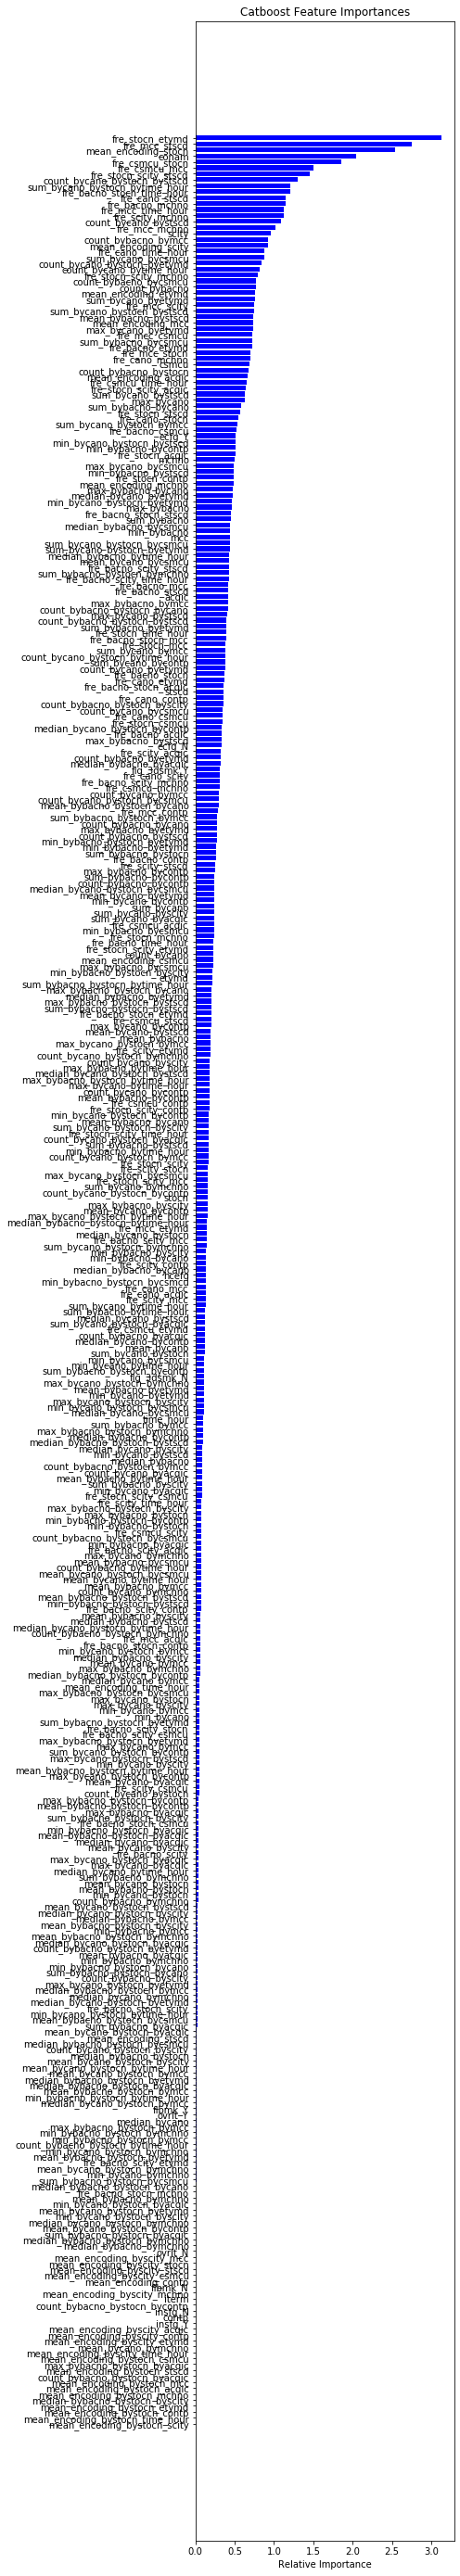

In [73]:
importances = clf.feature_importances_
indices = np.argsort(importances)
features = df_train_X.columns

plt.figure(figsize=(5,50)) # 調整長寬
plt.title('Catboost Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [ ]:
# df_import = pd.DataFrame({'colname':df_train_X.columns,'importances':clf.feature_importances_}
#             ).sort_values(by='importances',ascending=False)

In [ ]:
# pro = np.array([])
# idx = np.array([])
# for i in range(len(pred_pro)):
#     pro = np.append(pro, pred_pro[i].reshape(-1))
#     idx = np.append(idx, te_index[i])
# idx = idx.astype(int)
# oof = pd.DataFrame()
# oof['pro'] = pro
# oof.index = idx
# oof = oof.sort_index()
# oof['txkey'] = train['txkey'].values

In [ ]:
# oof.head()

In [ ]:
# oof.to_csv('oof_date.csv',index=None)

In [ ]:
# meta_feature = pd.DataFrame()
# meta_feature['txkey'] = test['txkey']
# meta_feature['feature'] = np.mean(meta_y,axis=1)

In [ ]:
# meta_feature.head()

In [ ]:
# meta_feature.to_csv('meta_feature_date.csv',index=None)

# 7. submission

In [74]:
df_train_y.fraud_ind.value_counts(normalize=True)

0.0    0.986672
1.0    0.013328
Name: fraud_ind, dtype: float64

In [75]:
## predict
predictions =  np.where(pred_pro4sub > 0.35,1,0)
pd.Series(predictions).value_counts(normalize=True)

0    0.985754
1    0.014246
dtype: float64

In [76]:
submission = pd.DataFrame({'txkey':df_test_id, 'fraud_ind': predictions})

In [77]:
submission.to_csv('submission_1113_v6_catbo.csv',index=None)